## YELP - EDA and graph preprocessing with PySpark

Members:

**1. Rolamjaya Hotmartua**

**2. YiChin Tzou**

**3. Zoey Chen**

### 1) Data Exploration

In [1]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import isnan, when, count, col, avg, first
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, BooleanType, DateType, FloatType
import pandas as pd
from functools import reduce
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
  .builder \
  .master('yarn') \
  .appName('YelpBigData') \
  .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/07 00:31:12 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/03/07 00:31:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/03/07 00:31:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/03/07 00:31:13 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [3]:
bucket = "msca-bdp-student-gcs/group3_final"
spark.conf.set('temporaryGcsBucket', bucket)

In [4]:
#from pyspark.context import SparkContext
#from graphframes import *

In [5]:
# #create Spark session
# spark = SparkSession.builder.appName('YelpBigDataML').config("spark.jars.packages", "graphframes:graphframes:0.8.1-spark2.4-s_2.11").getOrCreate()

# #change configuration settings on Spark 
# conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

# #print spark configuration settings
# spark.sparkContext.getConf().getAll()

#### a. Read data into Spark   

In [6]:
df_user = spark.read\
    .json("gs://msca-bdp-student-gcs/group3_final/yelp_academic_dataset_user.json" )

In [7]:
df_user.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [8]:
df_review = spark.read\
    .json("gs://msca-bdp-student-gcs/group3_final/yelp_academic_dataset_review.json" )

In [9]:
df_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [10]:
df_business = spark.read\
    .json("gs://msca-bdp-student-gcs/group3_final/yelp_academic_dataset_business.json" )

23/03/07 00:31:54 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
df_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [12]:
df_checkin = spark.read\
    .json("gs://msca-bdp-student-gcs/group3_final/yelp_academic_dataset_checkin.json" )

In [13]:
df_checkin.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)



In [14]:
df_tip = spark.read\
    .json("gs://msca-bdp-student-gcs/group3_final/yelp_academic_dataset_tip.json" )

In [15]:
df_tip.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [16]:
df_user.show(5)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|  name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|         3.91|    

In [17]:
df_review.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [18]:
df_business.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                null|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{null, null, null...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

In [19]:
df_checkin.show(5)

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|---kPU91CF4Lq2-Wl...|2020-03-13 21:10:...|
|--0iUa4sNDFiZFrAd...|2010-09-13 21:43:...|
|--30_8IhuyMHbSOcN...|2013-06-14 23:29:...|
|--7PUidqRWpRSpXeb...|2011-02-15 17:12:...|
|--7jw19RH9JKXgFoh...|2014-04-21 20:42:...|
+--------------------+--------------------+
only showing top 5 rows



In [20]:
df_tip.show(5)

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|3uLgwr0qeCNMjKenH...|               0|2012-05-18 02:17:21|Avengers time wit...|AGNUgVwnZUey3gcPC...|
|QoezRbYQncpRqyrLH...|               0|2013-02-05 18:35:10|They have lots of...|NBN4MgHP9D3cw--Sn...|
|MYoRNLb5chwjQe3c_...|               0|2013-08-18 00:56:08|It's open even wh...|-copOvldyKh1qr-vz...|
|hV-bABTK-glh5wj31...|               0|2017-06-27 23:05:38|Very decent fried...|FjMQVZjSqY8syIO-5...|
|_uN0OudeJ3Zl_tf6n...|               0|2012-10-06 19:43:09|Appetizers.. plat...|ld0AperBXk1h6Ubqm...|
+--------------------+----------------+-------------------+--------------------+--------------------+
only showing top 5 rows



#### Check Business Table

In [21]:
df_business.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                null|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{null, null, null...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

In [22]:
df_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

#### Flitering Restaurants and Food

In [23]:
df_restaurant_IL = df_business.filter(df_business.state.like("IL"))

In [24]:
df_restaurant_IL.show(5)

+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------+----------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|            city|               hours|is_open|  latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------+----------+--------------+--------------------+-----------+------------+-----+-----+
|     722 Holyoake Rd|{null, null, null...|LcAozWCMLGjwRboka...|Museums, Kids Act...|    Edwardsville|{9:30-17:30, 10:0...|      1|38.8043945|   -89.9497332|Edwardsville Chil...|      62025|          12|  4.5|   IL|
|        312 Piasa St|{null, null, u'fu...|ljxNT9p0y7YMPx0fc...|Restaurants, Spec...|           Alton|{16:0-22:0, 0:0-0...|      1| 38.8

In [25]:
df_restaurant_IL = df_restaurant_IL.filter(df_restaurant_IL.categories.like("%Restaurants%"))

In [26]:
df_restaurant_IL_rf = df_restaurant_IL.drop('attributes','int64_field_0','address','is_open','hours')

In [27]:

df_restaurant_IL_rf.show(5)

+--------------------+--------------------+----------------+----------+--------------+--------------------+-----------+------------+-----+-----+
|         business_id|          categories|            city|  latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+----------------+----------+--------------+--------------------+-----------+------------+-----+-----+
|ljxNT9p0y7YMPx0fc...|Restaurants, Spec...|           Alton| 38.896563|-90.1862032987|Tony's Restaurant...|      62002|          94|  3.0|   IL|
|EuRGgOwJ0g1vTj2R0...|Seafood, Restaurants|Fairview Heights|38.6012982|   -89.9896835|         Crafty Crab|      62208|          14|  2.5|   IL|
|uYBx50Yl_Jc-UYwFz...|Restaurants, Chic...|    Edwardsville|38.8105909|   -89.9524841|Chew Doin Fried C...|      62025|          10|  3.0|   IL|
|zjQDk4tZyhEroyqtk...|American (Traditi...|         Lebanon|38.6041071|   -89.8085329|The Cobblestone E...|      62254|          5

#### Filtering Reviews

In [28]:
df_review1 = df_review.drop('cool','funny','useful', 'date', 'review_id', 'compliment_count')


In [29]:
df_review1.show(5)

+--------------------+-----+--------------------+--------------------+
|         business_id|stars|                text|             user_id|
+--------------------+-----+--------------------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|  3.0|If you decide to ...|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|  5.0|I've taken a lot ...|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|  3.0|Family diner. Had...|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|  5.0|Wow!  Yummy, diff...|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|  4.0|Cute interior and...|bcjbaE6dDog4jkNY9...|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



#### Join the restaurant table & users together, will be able to see the users & their ratings for the restaurant

In [30]:
df_user_review_for_restaurant = df_restaurant_IL_rf.join(df_review1, ['business_id'], "inner").drop("text").drop("attributes")

In [31]:
df_user_review_for_restaurant.show(5)

+--------------------+--------------------+------------+-------------+--------------+--------------------+-----------+------------+-----+-----+-----+--------------------+
|         business_id|          categories|        city|     latitude|     longitude|                name|postal_code|review_count|stars|state|stars|             user_id|
+--------------------+--------------------+------------+-------------+--------------+--------------------+-----------+------------+-----+-----+-----+--------------------+
|WCVFqK84i2H5EClSo...|Sandwiches, Burge...|Granite City|    38.761132|    -90.084759|          Itty-Bitty|      62040|          33|  4.5|   IL|  5.0|LWTvg7RlyNLXIf482...|
|xR3inMR2KceU3b9dh...|American (Traditi...|Granite City|   38.7013281|   -90.1494623|Lascelles Granite...|      62040|          48|  4.0|   IL|  4.0|1EecTw-Iojid62ySM...|
|_uyLoz0BbrQIVmUEm...|  Greek, Restaurants|       Alton|   38.8879587|   -90.1582947|   Jimmy The Greek's|      62002|          33|  3.0|   IL|  

In [32]:
df_user_review_for_restaurant.printSchema()
dff= df_user_review_for_restaurant.drop("state")
dff.show(5)

root
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- stars: double (nullable = true)
 |-- state: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+--------------------+------------+-------------+--------------+--------------------+-----------+------------+-----+-----+--------------------+
|         business_id|          categories|        city|     latitude|     longitude|                name|postal_code|review_count|stars|stars|             user_id|
+--------------------+--------------------+------------+-------------+--------------+--------------------+-----------+------------+-----+-----+--------------------+
|WCVFqK84i2H5EClSo...|Sand

## 2.EDA

### Which business has the most reviews?

In [33]:
df_business.groupby(df_business.categories)\
    .count()\
    .sort("count").orderBy(["count"], ascending=[0])\
    .show(10)

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|Beauty & Spas, Na...| 1012|
|  Restaurants, Pizza|  935|
|Nail Salons, Beau...|  934|
|  Pizza, Restaurants|  823|
|Restaurants, Mexican|  728|
|Restaurants, Chinese|  708|
|Mexican, Restaurants|  672|
|Chinese, Restaurants|  651|
|  Food, Coffee & Tea|  508|
|Beauty & Spas, Ha...|  493|
+--------------------+-----+
only showing top 10 rows



In [34]:
from pyspark.sql.functions import split
df_business1 = df_business.withColumn("categories", split(df_business.categories, ", "))

from pyspark.sql.functions import explode
df_business1 = df_business1.select("business_id", explode("categories").alias("tag"))

from pyspark.sql.functions import count

df_business1 = df_business1.groupBy("tag").agg(count("business_id").alias("count"))

In [35]:
df_business1 = df_business1.sort("count", ascending=False)
df_business1.show()

+--------------------+-----+
|                 tag|count|
+--------------------+-----+
|         Restaurants|52268|
|                Food|27781|
|            Shopping|24395|
|       Home Services|14356|
|       Beauty & Spas|14292|
|           Nightlife|12281|
|    Health & Medical|11890|
|      Local Services|11198|
|                Bars|11065|
|          Automotive|10773|
|Event Planning & ...| 9895|
|          Sandwiches| 8366|
|American (Traditi...| 8139|
|         Active Life| 7687|
|               Pizza| 7093|
|        Coffee & Tea| 6703|
|           Fast Food| 6472|
|  Breakfast & Brunch| 6239|
|      American (New)| 6097|
|     Hotels & Travel| 5857|
+--------------------+-----+
only showing top 20 rows



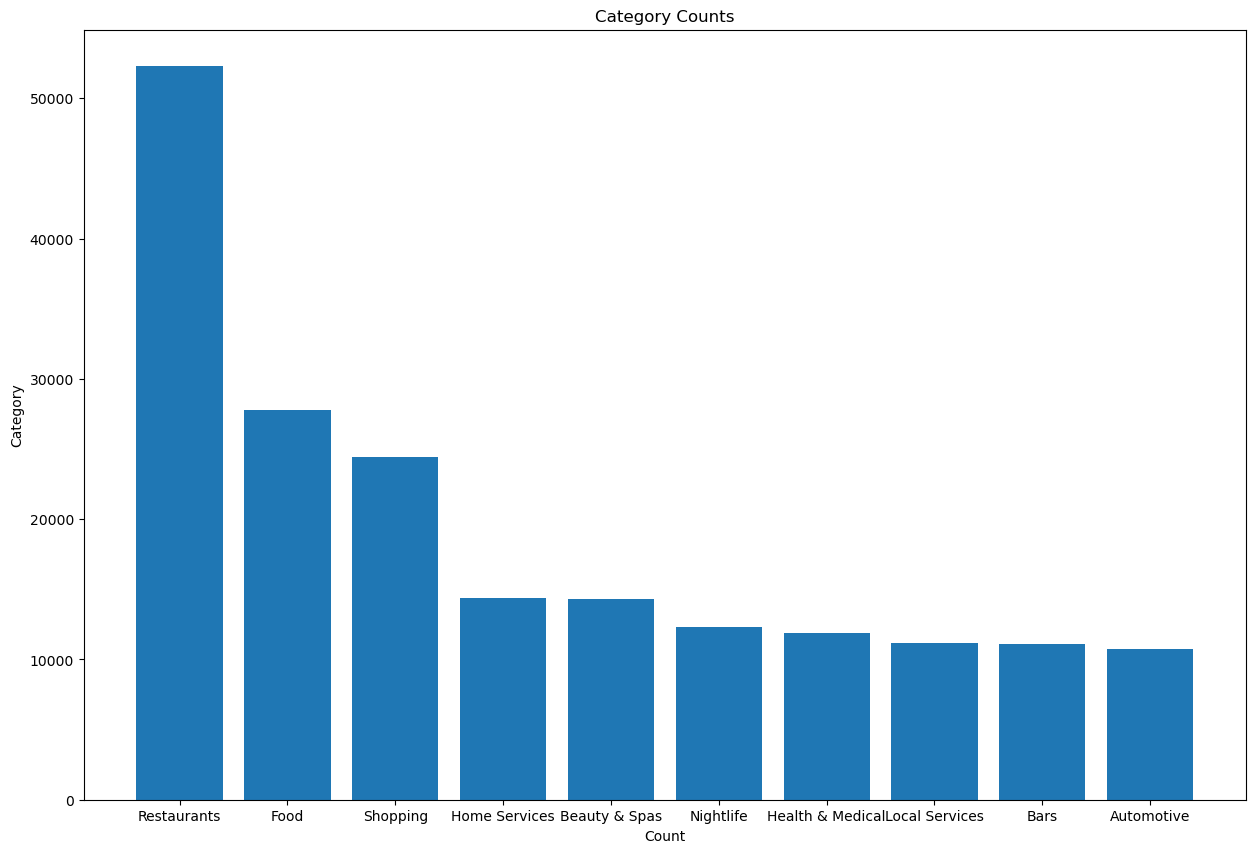

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
df_business1_pd = df_business1.limit(10).toPandas()
#colors = ['orange', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'black', 'cyan']
ax.bar(df_business1_pd['tag'], df_business1_pd['count'])
ax.set_xlabel("Count" )
ax.set_ylabel("Category")
ax.set_title("Category Counts")
plt.show()


### Rating distribution for restaurant in IL

In [37]:
df_business2 = df_restaurant_IL_rf.groupBy("stars").agg(count("business_id").alias("count"))

In [38]:
df_business2.show(5)

+-----+-----+
|stars|count|
+-----+-----+
|  3.5|  202|
|  4.5|  140|
|  2.5|  119|
|  1.0|    7|
|  4.0|  189|
+-----+-----+
only showing top 5 rows



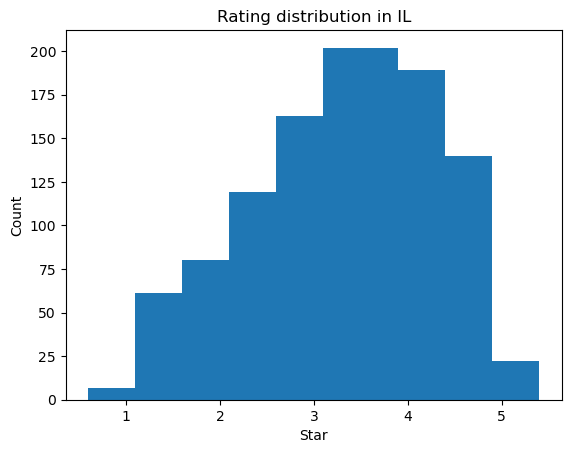

In [39]:
fig, ax = plt.subplots()
df_business2_pd = df_business2.toPandas()
#colors = ['orange', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'black', 'cyan']
ax.bar(df_business2_pd['stars'], df_business2_pd['count'])
ax.set_xlabel("Star" )
ax.set_ylabel("Count")
ax.set_title("Rating distribution in IL​")
plt.show()


### Reviews counts in each restaurant

In [40]:
df_business3=df_restaurant_IL_rf.select('name','review_count').orderBy(["review_count"], ascending=[0]).limit(10)
df_business3.show()

+--------------------+------------+
|                name|review_count|
+--------------------+------------+
|     BEAST Craft BBQ|         583|
|Lotawata Creek So...|         550|
|     Cleveland-Heath|         455|
|Hop House Souther...|         407|
|Eckert's Country ...|         401|
|Peel Wood Fired P...|         385|
|Fast Eddie's Bon Air|         368|
|Peel Wood Fired P...|         357|
|Hofbräuhaus St Lo...|         298|
|4204 Main Street ...|         260|
+--------------------+------------+



/tmp/ipykernel_16208/1964299246.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_business3_pd['name'], rotation=90)


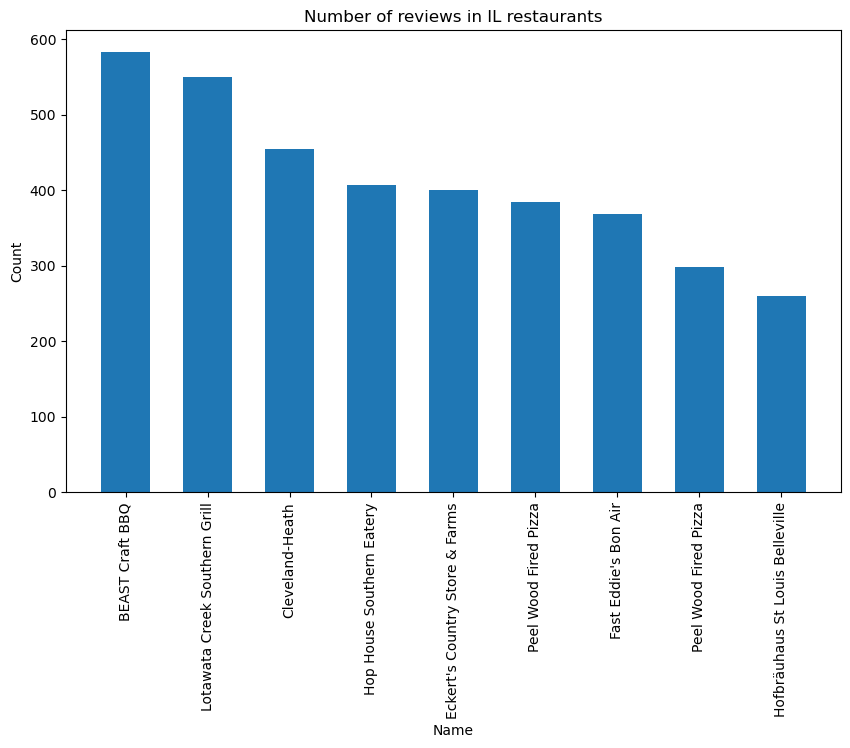

In [41]:
fig, ax = plt.subplots(figsize =(10,6))

df_business3_pd = df_business3.toPandas()
#colors = ['orange', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'black', 'cyan']
ax.bar(df_business3_pd['name'], df_business3_pd['review_count'], width=0.6)
ax.set_xlabel("Name" )
ax.set_ylabel("Count")
ax.set_title("Number of reviews in IL restaurants")
ax.set_xticklabels(df_business3_pd['name'], rotation=90)
plt.show()

### reviews count in cities​

In [42]:
df_restaurant_IL_rf.show(5)

+--------------------+--------------------+----------------+----------+--------------+--------------------+-----------+------------+-----+-----+
|         business_id|          categories|            city|  latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+----------------+----------+--------------+--------------------+-----------+------------+-----+-----+
|ljxNT9p0y7YMPx0fc...|Restaurants, Spec...|           Alton| 38.896563|-90.1862032987|Tony's Restaurant...|      62002|          94|  3.0|   IL|
|EuRGgOwJ0g1vTj2R0...|Seafood, Restaurants|Fairview Heights|38.6012982|   -89.9896835|         Crafty Crab|      62208|          14|  2.5|   IL|
|uYBx50Yl_Jc-UYwFz...|Restaurants, Chic...|    Edwardsville|38.8105909|   -89.9524841|Chew Doin Fried C...|      62025|          10|  3.0|   IL|
|zjQDk4tZyhEroyqtk...|American (Traditi...|         Lebanon|38.6041071|   -89.8085329|The Cobblestone E...|      62254|          5

In [43]:
df_business4=df_restaurant_IL_rf.groupBy("city").agg(count("business_id").alias("count"))\
            .orderBy(["count"], ascending=[0])
df_business4.show()

+----------------+-----+
|            city|count|
+----------------+-----+
|      Belleville|  146|
|    Edwardsville|  128|
|           Alton|   84|
|Fairview Heights|   77|
|    Collinsville|   71|
|        O'Fallon|   56|
|    Granite City|   50|
|        Waterloo|   32|
|        Columbia|   30|
|      Wood River|   29|
|            Troy|   27|
|        O Fallon|   26|
|         Swansea|   22|
|         Lebanon|   19|
|     Glen Carbon|   18|
|       Maryville|   17|
|         Godfrey|   16|
|      Caseyville|   14|
|          Shiloh|   14|
|       Millstadt|   13|
+----------------+-----+
only showing top 20 rows



/tmp/ipykernel_16208/3615806925.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_business4_pd['city'], rotation=90)


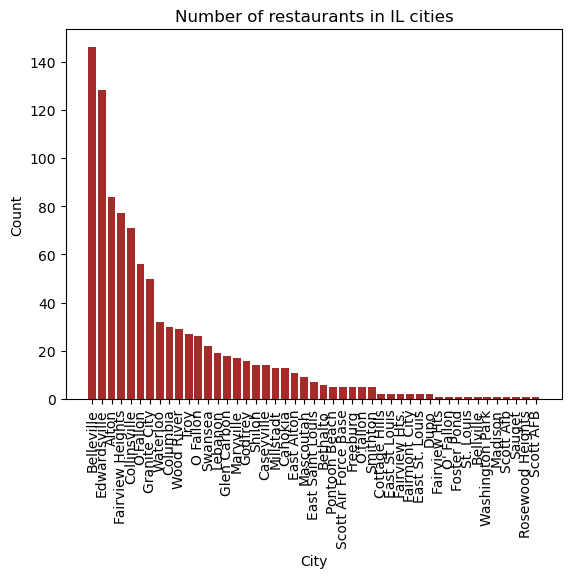

In [44]:
fig, ax = plt.subplots()
df_business4_pd = df_business4.toPandas()
#colors = ['orange', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'black', 'cyan']
ax.bar(df_business4_pd['city'], df_business4_pd['count'],color='brown')
ax.set_xlabel("City" )
ax.set_ylabel("Count")
ax.set_title("Number of restaurants in IL cities")
ax.set_xticklabels(df_business4_pd['city'], rotation=90)

plt.show()

### Number of Reviews over the Year

In [45]:
#Create dataframes for vertices and edges 
from pyspark.sql.functions import split, explode, col,trim,lit,size,avg,year,when
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

In [51]:
df_review = df_review.withColumnRenamed("cool","cool_rev")\
            .withColumnRenamed("funny","funny_rev")\
            .withColumnRenamed("useful","useful_rev")\
            .withColumnRenamed("stars","stars_rev")

In [52]:
restaurants = df_business.filter(col("categories").like("%Restaurants%"))

In [53]:
joined_df = df_review.join(restaurants, "business_id", "inner")

In [54]:
joined_df = joined_df.join(df_user, "user_id", "inner")

In [55]:
joined_df_date = joined_df.withColumn("date_rev", col("date").cast("date")).drop("date")

In [56]:
joined_df_date = joined_df_date.withColumn("response", col("cool_rev") + col("funny_rev") + col("useful_rev"))

In [57]:
joined_df_date = joined_df_date.withColumn("friends_array", split(col("friends"), ", ")).withColumn("count_friends", size(col("friends_array")))

In [58]:
joined_df_trunc = joined_df_date.select(["date_rev","user_id","business_id","review_id","stars_rev","response","count_friends"])

In [59]:
joined_df_date = joined_df_date.withColumn("since_rev", col("yelping_since").cast("date")).drop("yelping_since")\
                    .withColumn("since_year", year(col("since_rev")))

In [60]:
joined_df_trunc.printSchema()

root
 |-- date_rev: date (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars_rev: double (nullable = true)
 |-- response: long (nullable = true)
 |-- count_friends: integer (nullable = false)



In [61]:
joined_df_trunc.count()

4724464

In [62]:
daily_count = joined_df_trunc.groupby("date_rev").count()

In [63]:
window = Window.orderBy('date_rev')
daily_count = daily_count.withColumn("rolling_avg_count", avg(col("count")).over(window.rowsBetween(-6, 0)))

In [64]:
comment_daily = daily_count.toPandas()

23/03/07 00:38:39 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:38:39 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:38:41 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:38:52 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:39:01 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [65]:
comment_daily.head(10)

,date_rev,count,rolling_avg_count
0,2005-02-16,2,2.000000
1,2005-03-01,6,4.000000
2,2005-03-02,1,3.000000
3,2005-03-04,3,3.000000
4,2005-03-08,4,3.200000
5,2005-03-09,10,4.333333
6,2005-03-10,6,4.571429
7,2005-03-12,2,4.571429
8,2005-03-14,4,4.285714
9,2005-03-15,2,4.428571


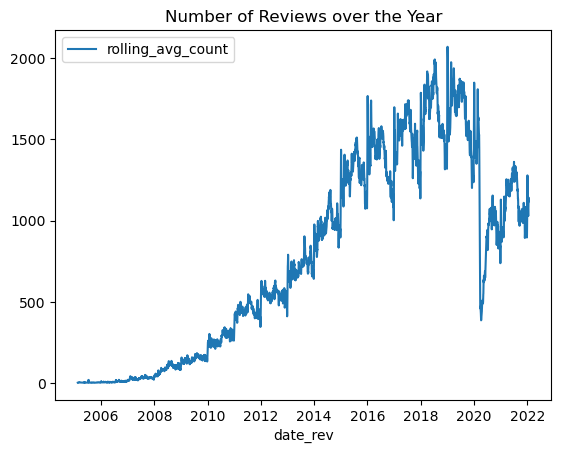

In [66]:
comment_daily.plot(kind= "line", x = "date_rev", y = "rolling_avg_count", title = "Number of Reviews over the Year");

In [67]:
total_review = df_review.withColumn("date_rev", col("date").cast("date")).drop("date").groupby("date_rev").count()

In [68]:
window = Window.orderBy('date_rev')
total_review = total_review.withColumn("rolling_avg_count", avg(col("count")).over(window.rowsBetween(-6, 0)))

In [69]:
total_review = total_review.toPandas()

23/03/07 00:39:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:39:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:39:19 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:39:19 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:39:19 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [70]:
total_review.head(10)

,date_rev,count,rolling_avg_count
0,2005-02-16,3,3.000000
1,2005-03-01,7,5.000000
2,2005-03-02,2,4.000000
3,2005-03-04,4,4.000000
4,2005-03-08,5,4.200000
5,2005-03-09,12,5.500000
6,2005-03-10,9,6.000000
7,2005-03-12,4,6.142857
8,2005-03-14,6,6.000000
9,2005-03-15,3,6.142857


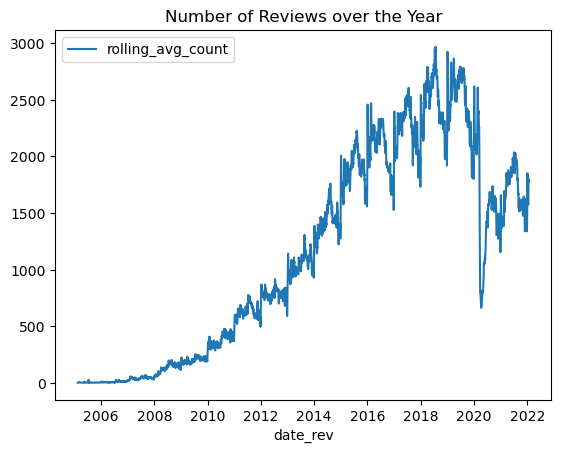

In [71]:
total_review.plot(kind= "line", x = "date_rev", y = "rolling_avg_count", title = "Number of Reviews over the Year");

In [72]:
resto_state = restaurants.groupby(col("state")).count().orderBy("count", ascending=False)

In [73]:
resto_state_pd = resto_state.toPandas()

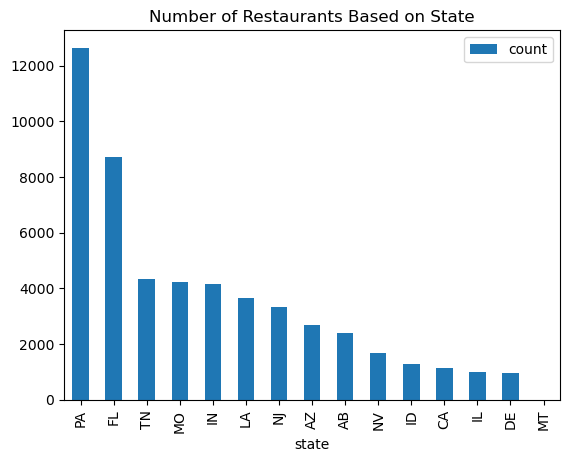

In [74]:
resto_15 = resto_state_pd.iloc[:15,:]
resto_15.plot(kind = "bar",x = "state",y="count", title="Number of Restaurants Based on State" );

In [75]:
resto_comment_state = joined_df_date.groupby(col("state")).count().orderBy("count", ascending=False)

In [76]:
resto_comment_state_pd = resto_comment_state.toPandas()

In [77]:
resto_comment_state_pd.head()

,state,count
0,PA,1100249
1,FL,792131
2,LA,558340
3,TN,434697
4,MO,354604


<AxesSubplot:xlabel='state'>

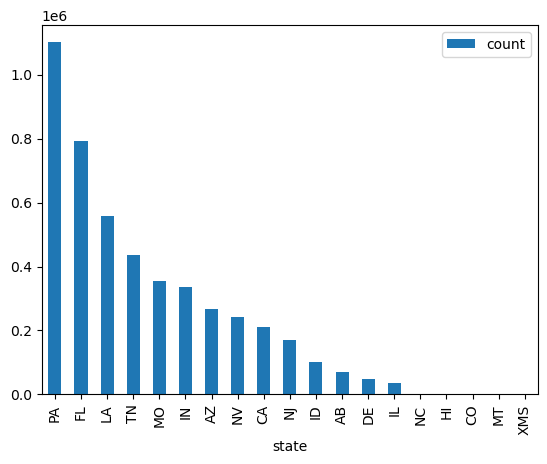

In [78]:
#resto_10 = resto_state_pd.iloc[:15,:]
resto_comment_state_pd.plot(kind = "bar",x = "state",y="count")

In [79]:
resto_comment_state_pd[resto_comment_state_pd.state == "IL"]

,state,count
13,IL,36870


In [80]:
# define the bin edges and labels
bin_edges = [0, 1, 2, 3, 4, 5]
bin_labels = ["0-1", "1-2", "2-3", "3-4", "4-5"]

# create a new column with the bin labels for each value in the value column
restaurants = restaurants.withColumn("restaurant star", when(col("stars") < bin_edges[1], bin_labels[0])
                          .when(col("stars") < bin_edges[2], bin_labels[1])\
                                     .when(col("stars") < bin_edges[3], bin_labels[2])\
                                     .when(col("stars") < bin_edges[4], bin_labels[3])
                          .otherwise(bin_labels[4]))

In [81]:
resto_star = restaurants.groupby(col("restaurant star")).count().orderBy("restaurant star", ascending=True)

In [82]:
resto_star_pd = resto_star.toPandas()

<AxesSubplot:title={'center':'Number of Restaurants based on Star'}, ylabel='restaurant star'>

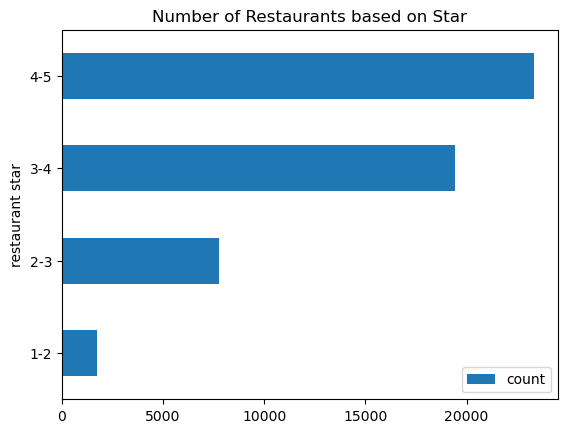

In [83]:
resto_star_pd.plot(kind="barh",x="restaurant star", y="count", title="Number of Restaurants based on Star")

In [84]:
df_user = df_user.withColumn("since_rev", col("yelping_since").cast("date")).drop("yelping_since")\
                    .withColumn("since_year", year(col("since_rev")))

In [85]:
user_count = df_user.groupby(col("since_year")).count().orderBy("since_year", ascending=False)

In [86]:
from pyspark.sql.functions import col, sum
from pyspark.sql.window import Window

# create a window specification for the cumulative sum
window_spec = Window.orderBy("since_year").rowsBetween(Window.unboundedPreceding, Window.currentRow)

# create a new dataframe with cumulative sum for each row
df_cumsum = user_count.select(
    "*",
        sum(col("count")).over(window_spec).alias(f"cumulative_sum")
)


In [87]:
df_cumsum_pd = df_cumsum.toPandas()

23/03/07 00:39:47 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:39:47 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:39:55 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:39:55 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:39:55 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [88]:
df_cumsum_pd.head()

,since_year,count,cumulative_sum
0,2004,90,90
1,2005,937,1027
2,2006,5423,6450
3,2007,15340,21790
4,2008,31097,52887


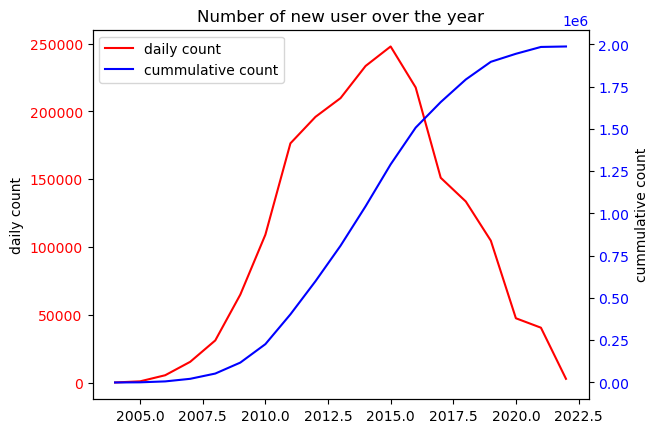

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# create a figure and a set of twin axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# create a line plot for y1 on the first y-axis
ax1.plot(df_cumsum_pd['since_year'], df_cumsum_pd['count'], label='daily count', color='red')
ax1.set_ylabel('daily count')
ax1.tick_params(axis='y', labelcolor='red')

# create a line plot for y2 on the second y-axis
ax2.plot(df_cumsum_pd['since_year'], df_cumsum_pd['cumulative_sum'], label='cummulative count', color='blue')
ax2.set_ylabel('cummulative count')
ax2.tick_params(axis='y', labelcolor='blue')

# add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title("Number of new user over the year")
# show the plot
plt.show();


In [90]:
joined_df_trunc.show(5)

+----------+--------------------+--------------------+--------------------+---------+--------+-------------+
|  date_rev|             user_id|         business_id|           review_id|stars_rev|response|count_friends|
+----------+--------------------+--------------------+--------------------+---------+--------+-------------+
|2014-07-13|--6lqYpHZCBbpW5z2...|mUI4DJagyUyu76qnR...|G2_8hBYPAQA8HPm3H...|      1.0|       0|            1|
|2014-09-07|--Kwhcbkh7jxkhVVQ...|ORL4JE6tz3rJxVqkd...|bSz0fCiKRJAB0qI9l...|      4.0|       0|           92|
|2014-09-06|--Kwhcbkh7jxkhVVQ...|tIvfmgT1qMeAEQf8C...|G4YEeMu4Sj1XUEmlJ...|      4.0|       1|           92|
|2014-09-05|--Kwhcbkh7jxkhVVQ...|arQfMJal1tl67Z96R...|FQLQXb-Hs-MlbIJf8...|      4.0|       1|           92|
|2019-08-25|--RJK834fiQXm21Vp...|aIoUwpy5ZFQXUDxWM...|QPF7spAqCc-D81GeX...|      1.0|       0|            1|
+----------+--------------------+--------------------+--------------------+---------+--------+-------------+
only showing top 5 

In [91]:
joined_df_user = joined_df_trunc.dropDuplicates(["date_rev", "user_id"])

In [92]:
user_perday = joined_df_user.groupby("date_rev").count()

In [93]:
window = Window.orderBy('date_rev')
user_perday = user_perday.withColumn("rolling_avg_count", avg(col("count")).over(window.rowsBetween(-6, 0)))

In [94]:
user_perday_pd = user_perday.toPandas()

23/03/07 00:40:26 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:40:26 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:40:27 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:40:41 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 00:40:49 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

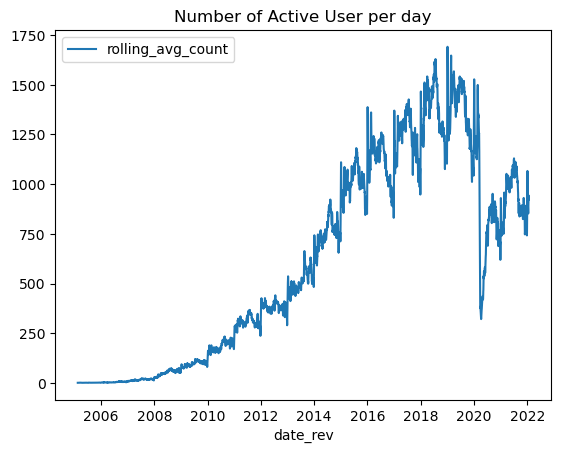

In [95]:
user_perday_pd.plot(kind= "line", x = "date_rev", y = "rolling_avg_count", title = "Number of Active User per day");

### 3. Slicing DF for graph analysis

In [96]:
review_count = joined_df.groupby("user_id").count().orderBy("count", ascending=False)

In [97]:
review_count = review_count.withColumnRenamed("count", "resto_review_count").withColumnRenamed("user_id", "id")

In [98]:
user_restaurant = df_user.join(review_count, review_count.id == df_user.user_id,"left")

In [99]:
df_user_2000 = user_restaurant.orderBy("resto_review_count", ascending=False).limit(2000)

In [100]:
#df_user_2000.write.format("json").save("gs://msca-bdp-student-gcs/group3_final/top_200_users.json")

In [101]:
from pyspark.sql.functions import split, explode, col,trim,lit,size

edges_friends = df_user_2000.select(["user_id","friends"]) 

df_expand = edges_friends.withColumn("friends", split(col("friends"), ","))  # split the friends column by comma
df_expand = df_expand.select(col("*"), explode(col("friends")).alias("friend"))  # explode the friend column

# remove leading and trailing whitespace from "my_column"
df_expand = df_expand.withColumn("friend", trim(df_expand["friend"]))

df_expand = df_expand.withColumn("relationship", lit("friends"))

cols_to_drop = ["friends"]
df_expand = df_expand.drop(*cols_to_drop)

edges = df_expand

In [102]:
distinct_names = edges.select("friend").distinct()

In [103]:
distinct_names_2 = edges.select("user_id").distinct()

In [104]:
distinct_names = distinct_names.union(distinct_names_2).select("friend").distinct() #341097

In [105]:
all_resto_users_2000 = distinct_names.join(user_restaurant, user_restaurant.user_id == distinct_names.friend, "left")

In [106]:
#Create dataframes for vertices and edges 
cols_to_drop = ["friends","friends_array","friend","id"]
all_resto_users_2000 = all_resto_users_2000.withColumn("response_in", col("compliment_cool")+col("compliment_cute")+col("compliment_funny")+\
                                                    col("compliment_hot")+col("compliment_list")+col("compliment_more")+\
                                                    col("compliment_note")+col("compliment_photos")+col("compliment_plain")+\
                                                    col("compliment_profile")+col("compliment_writer"))\
                            .drop("compliment_cool","compliment_cute","compliment_funny",\
                                    "compliment_hot","compliment_list","compliment_more",\
                                    "compliment_note","compliment_photos","compliment_plain",\
                                    "compliment_profile","compliment_writer")
all_resto_users_2000 = all_resto_users_2000.withColumn("response_out", col("cool") + col("funny") + col("useful")).drop("cool","funny","useful")
all_resto_users_2000 = all_resto_users_2000.withColumn("friends_array", split(col("friends"), ", ")).withColumn("count_friends", size(col("friends_array")))
vertices = all_resto_users_2000.drop(*cols_to_drop)

In [110]:
vertices.show(5)

+-------------+--------------------+----+---------+------------+--------------------+----------+----------+------------------+-----------+------------+-------------+
|average_stars|               elite|fans|     name|review_count|             user_id| since_rev|since_year|resto_review_count|response_in|response_out|count_friends|
+-------------+--------------------+----+---------+------------+--------------------+----------+----------+------------------+-----------+------------+-------------+
|         null|                null|null|     null|        null|                null|      null|      null|              null|       null|        null|           -1|
|         3.46|2010,2011,2012,20...|  55|     Sara|        1760|-3s52C4zL_DHRK0UL...|2010-05-16|      2010|               166|        142|        2507|           18|
|         3.58|                    |   0|   Mariam|          31|-49VO6EnRppS5vehd...|2010-10-15|      2010|                 3|          5|          31|           25|
|   

There are several "friends" that is no longer in user database but still maintained in the friends' list of user. We assume that the user has deleted its profile, however, the friends list does not updated. Thus, we remove the vertices and edges that has those characteristics.

In [111]:
user_notnull = vertices.filter(col("count_friends")!=-1).withColumnRenamed("user_id", "id_notnull").select("id_notnull")

In [112]:
new_edges = edges.join(user_notnull, user_notnull.id_notnull == edges.friend, "inner").drop("id_notnull")#339k

In [113]:
new_vertices = vertices.filter(col("count_friends")!=-1) #117k

In [114]:
#expanding step 2
edges_friends = user_notnull.join(df_user, df_user.user_id == user_notnull.id_notnull,"left").select(["user_id","friends"]).drop("id_notnull")

df_expand = edges_friends.withColumn("friends", split(col("friends"), ","))  # split the friends column by comma
df_expand = df_expand.select(col("*"), explode(col("friends")).alias("friend"))  # explode the friend column

# remove leading and trailing whitespace from "my_column"
df_expand = df_expand.withColumn("friend", trim(df_expand["friend"]))

df_expand = df_expand.withColumn("relationship", lit("friends"))

cols_to_drop = ["friends"]
df_expand = df_expand.drop(*cols_to_drop)

additional_edges = df_expand.join(user_notnull, user_notnull.id_notnull == df_expand.friend, "inner").drop("id_notnull")

In [115]:
additional_edges.show()

+--------------------+--------------------+------------+
|             user_id|              friend|relationship|
+--------------------+--------------------+------------+
|VjA1teP4BA2y9ZNzf...|--Vu3Gux9nPnLcG9y...|     friends|
|vHc-UrI9yfL_pnnc6...|--Vu3Gux9nPnLcG9y...|     friends|
|hZ-ZtZ3bqZg6GhWep...|-01TD28Dt9-3-bEvi...|     friends|
|9oAk1mL3fzC_2ixGc...|-0SqALqeWmInVftG_...|     friends|
|OrnQ04JCGie8Q2ymF...|-0SqALqeWmInVftG_...|     friends|
|_1-ZUx7DdoGBe45u0...|-0SqALqeWmInVftG_...|     friends|
|pdq8mplROSDvKyMtR...|-0SqALqeWmInVftG_...|     friends|
|Ae1atVuqSF8r5Qkch...|-0SqALqeWmInVftG_...|     friends|
|MeDuKsZcnI3IU2g7O...|-0SqALqeWmInVftG_...|     friends|
|Ot7pvG56inGGnXYM0...|-0SqALqeWmInVftG_...|     friends|
|jy_RGAeAvNeCv5BxZ...|-0SqALqeWmInVftG_...|     friends|
|lS-wxXFJWxVdbA1OA...|-0SqALqeWmInVftG_...|     friends|
|q_cYc9EJN1fzV7zwz...|-0SqALqeWmInVftG_...|     friends|
|zDltf7SGyDANcA6nd...|-0SqALqeWmInVftG_...|     friends|
|Nlfemj273YV_Ro3dw...|-0SqALqeW

In [116]:
edges = new_edges.union(additional_edges)